In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report


import warnings
warnings.filterwarnings("ignore", "use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", "Series.__getitem__ treating keys as positions is deprecated")

- While doing EDA make a list called steps_to_try_out_in_preprocessing, to which you add things to do in preprocessing pipeline based on the how the data looks in EDA.
- Import an image => Runner | Assignment_2.ipynb

We infer answers for the following questions in _EDA_ so that we have an idea of WHAT to do in _PRE-PROCESSING_ :-
 1. Does the dataset contain missing values ?
 2. How many passengers survived ?
 3.  Is the likelihood of survival dependent on gender ?
 4. Is the likelihood of survival dependent on age ?
 5. Does survival have any correlation with class ?
 6. Does Name give us any information ?
 7. Did paying the ticket price influence the chance of survival?
 8. Could the place of embarkation influence the chance of survival? => Intuition says that it does not have any dependance on survival
 9. Does the number of children/siblings/spouses or parents on board influence the chance of survival?

All the code, all submissions, other techniques I used throughout this assignment are available in the repository :- [My Machine Learning Exploration Github Repo](https://github.com/Niranjan-GopaL/Exploring_Machine_Learning__)

# EDA

In [122]:
# Some useful functions used repeatedly throughout EDA :- 

def bar_chart_stacked(dataset, feature, stacked = True):
    survived = dataset[dataset['Survived'] == 1][feature].value_counts()
    dead     = dataset[dataset['Survived'] == 0][feature].value_counts()
    
    df_survived_dead = pd.DataFrame([survived,dead])
    
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))
    
    
def list_0_or_1_based_on_feature(dataset,feature='Sex' ):
    return ( dataset.groupby(feature).Survived.mean() * 100 ).to_frame()

In [123]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

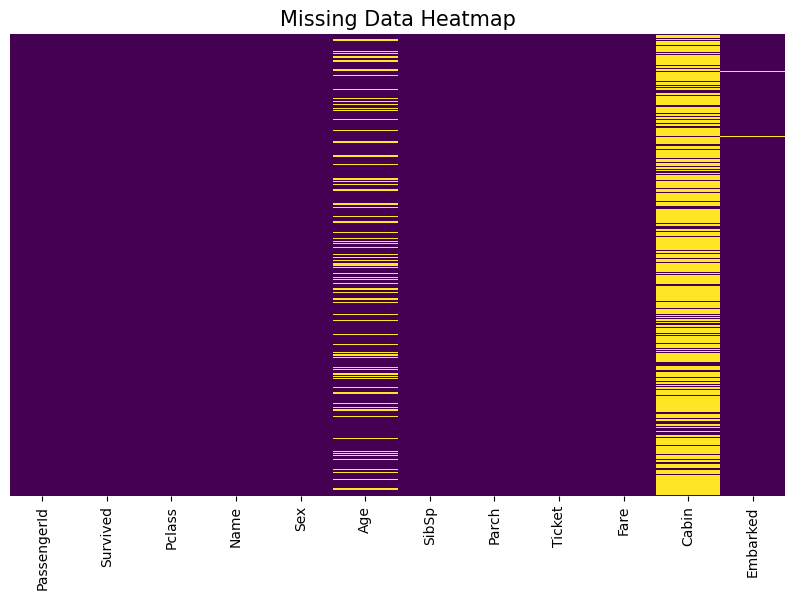

Age         140
Cabin       553
Embarked      2
dtype: int64


In [124]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Data Heatmap", fontsize=15)
plt.show()

missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0])

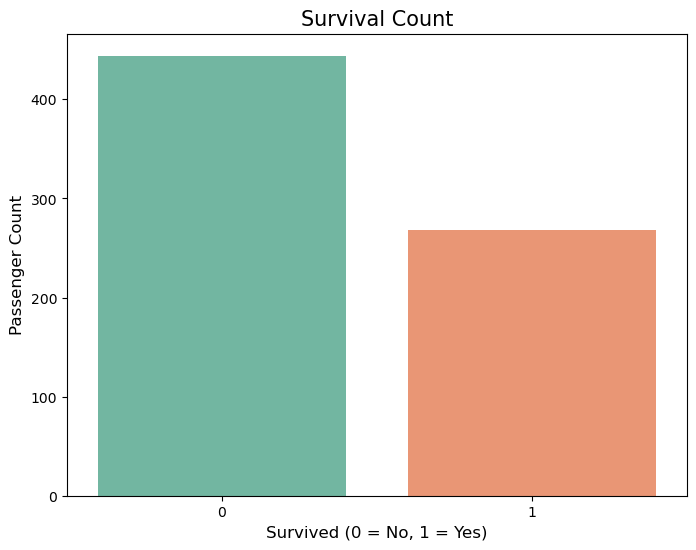

Survived: 37.64%, Did not survive: 62.36%


In [125]:
# Survival count plot
plt.figure(figsize=(8,6))
sns.countplot(x='Survived', data=train_df, palette='Set2')
plt.title('Survival Count', fontsize=15)
plt.xlabel('Survived (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Passenger Count', fontsize=12)
plt.show()

# Survival percentages
survived_percent = train_df['Survived'].value_counts(normalize=True) * 100
print(f"Survived: {survived_percent[1]:.2f}%, Did not survive: {survived_percent[0]:.2f}%")

In [126]:
train_df['Sex'].value_counts().to_frame()

,count
Sex,
male,467
female,245


In [127]:
list_0_or_1_based_on_feature(train_df,'Sex')

,Survived
Sex,
female,73.877551
male,18.629550


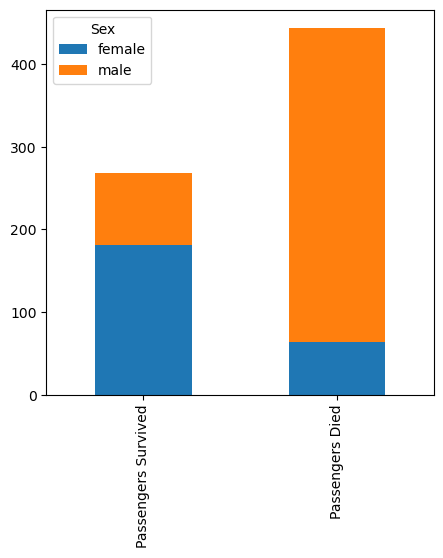

In [128]:
bar_chart_stacked(train_df, 'Sex')

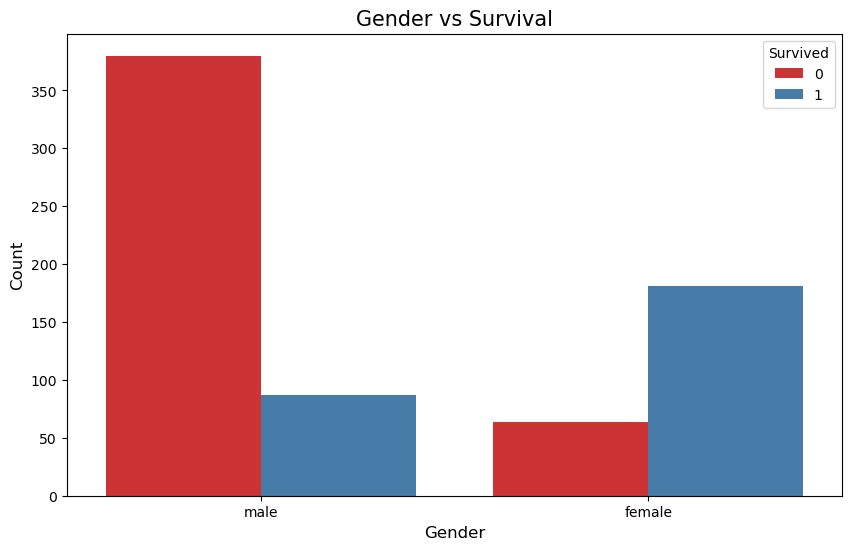

Survival Rate (Male): 18.63%
Survival Rate (Female): 73.88%


In [129]:
# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(str)

# Gender-wise survival stacked bar chart
plt.figure(figsize=(10,6))
sns.countplot(x='Sex', hue='Survived', data=train_df, palette='Set1')
plt.title('Gender vs Survival', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Survived', loc='upper right')
plt.show()


# Revert the 'Label' column back to numpy.int64
train_df['Survived'] = train_df['Survived'].astype(np.int64)


# Survival probability by gender
gender_survival_rate = train_df.groupby('Sex')['Survived'].mean() * 100
print(f"Survival Rate (Male): {gender_survival_rate[1]:.2f}%")
print(f"Survival Rate (Female): {gender_survival_rate[0]:.2f}%")

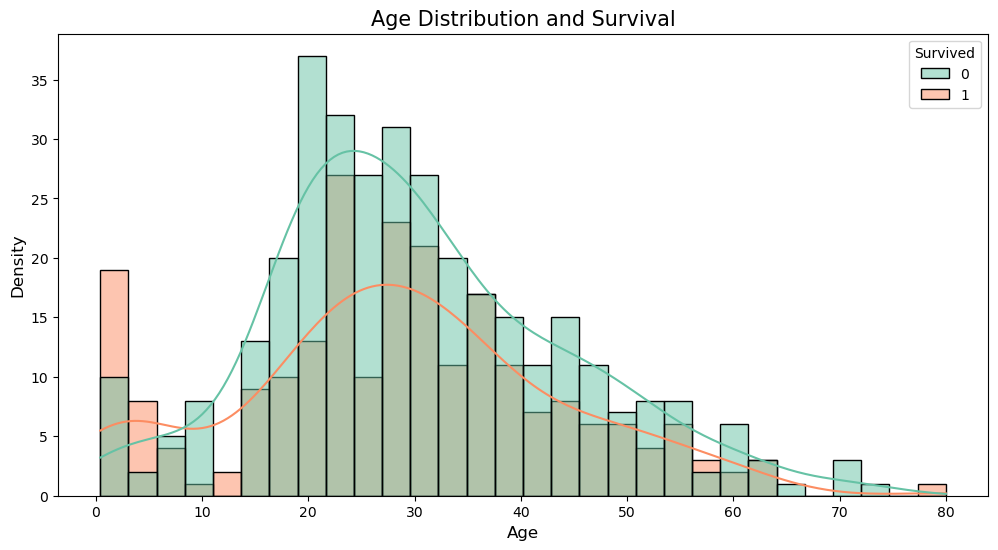

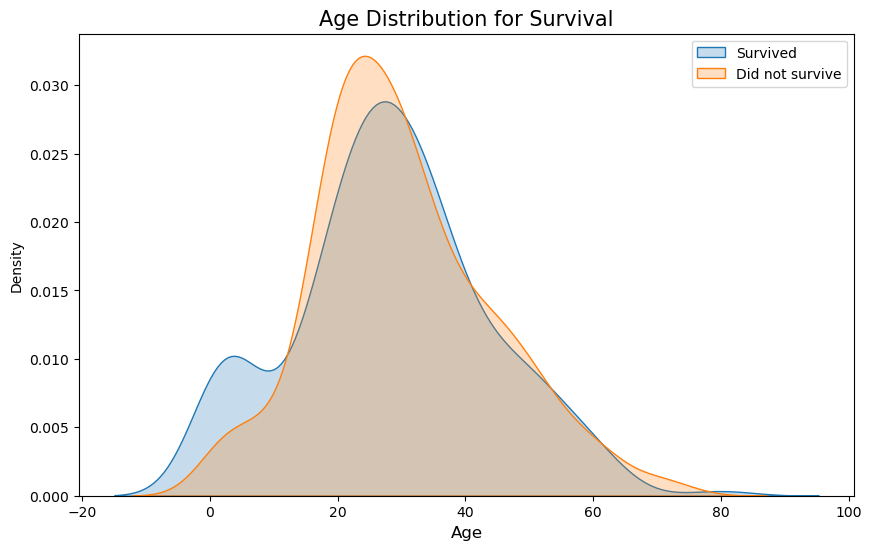

Correlation between Age and Survival: -0.06


In [130]:
# Age distribution with survival overlay
plt.figure(figsize=(12,6))

# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(str)


sns.histplot(data=train_df, x='Age', hue='Survived', kde=True, palette='Set2', bins=30)
plt.title('Age Distribution and Survival', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

# Revert the 'Label' column back to numpy.int64
train_df['Survived'] = train_df['Survived'].astype(np.int64)


# KDE plot for age and survival
plt.figure(figsize=(10,6))
sns.kdeplot(train_df.loc[train_df['Survived'] == 1, 'Age'], label='Survived', fill=True)
sns.kdeplot(train_df.loc[train_df['Survived'] == 0, 'Age'], label='Did not survive', fill=True)
plt.title('Age Distribution for Survival', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.legend()
plt.show()

# Age survival correlation
age_survival_corr = train_df[['Age', 'Survived']].corr()
print(f"Correlation between Age and Survival: {age_survival_corr.iloc[0, 1]:.2f}")


In [131]:
pd.pivot_table(train_df, index = 'Survived', columns= 'Pclass', values = 'Ticket', aggfunc ='count')

Pclass,1,2,3
Survived,,,
0,64,78,302
1,99,73,96


In [132]:
list_0_or_1_based_on_feature(train_df,'Pclass')

,Survived
Pclass,
1,60.736196
2,48.344371
3,24.120603


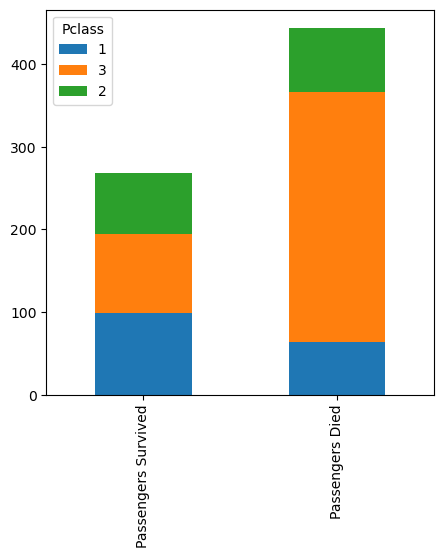

In [133]:
bar_chart_stacked(train_df, 'Pclass')

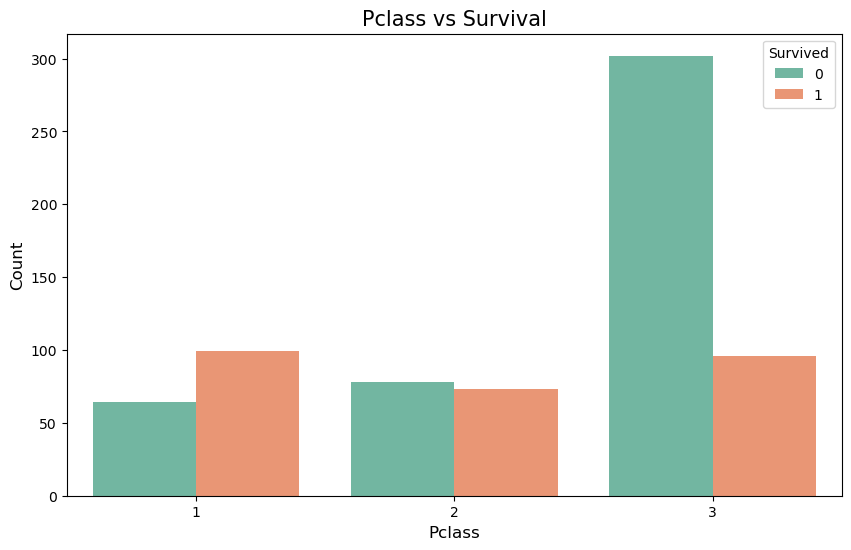

Survival Rate (1st class): 60.74%
Survival Rate (2nd class): 48.34%
Survival Rate (3rd class): 24.12%


In [134]:
# Class-wise survival stacked bar chart
plt.figure(figsize=(10,6))

train_df['Survived'] = train_df['Survived'].astype(str)

sns.countplot(x='Pclass', hue='Survived', data=train_df, palette='Set2')
plt.title('Pclass vs Survival', fontsize=15)
plt.xlabel('Pclass', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Survived', loc='upper right')
plt.show()

train_df['Survived'] = train_df['Survived'].astype(np.int64)

# Survival probability by Pclass
pclass_survival_rate = train_df.groupby('Pclass')['Survived'].mean() * 100
print(f"Survival Rate (1st class): {pclass_survival_rate[1]:.2f}%")
print(f"Survival Rate (2nd class): {pclass_survival_rate[2]:.2f}%")
print(f"Survival Rate (3rd class): {pclass_survival_rate[3]:.2f}%")


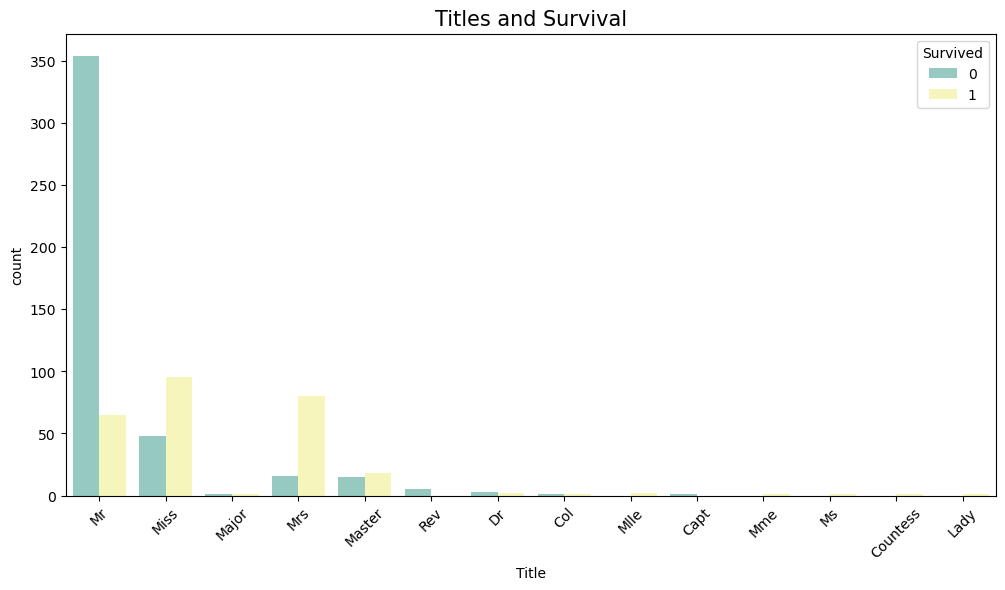

Title
Capt          0.000000
Col          50.000000
Countess    100.000000
Dr           40.000000
Lady        100.000000
Major        50.000000
Master       54.545455
Miss         66.433566
Mlle        100.000000
Mme         100.000000
Mr           15.513126
Mrs          83.333333
Ms          100.000000
Rev           0.000000
Name: Survived, dtype: float64


In [135]:
# Extract titles from names
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
plt.figure(figsize=(12,6))

# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(str)

sns.countplot(x='Title', hue='Survived', data=train_df, palette='Set3')
plt.title('Titles and Survival', fontsize=15)
plt.xticks(rotation=45)
plt.show()

# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(np.int64)

# Titles with survival rates
title_survival_rate = train_df.groupby('Title')['Survived'].mean() * 100
print(title_survival_rate)

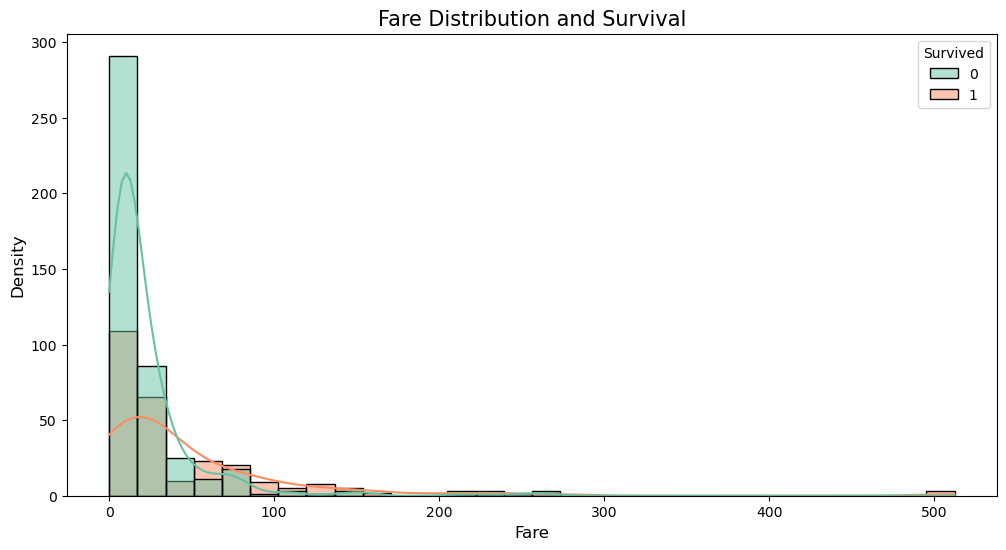

Correlation between Fare and Survival: 0.25


In [136]:
# Fare distribution with survival overlay
plt.figure(figsize=(12,6))
sns.histplot(data=train_df, x='Fare', hue='Survived', kde=True, palette='Set2', bins=30)
plt.title('Fare Distribution and Survival', fontsize=15)
plt.xlabel('Fare', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

# Correlation between Fare and Survival
fare_survival_corr = train_df[['Fare', 'Survived']].corr()
print(f"Correlation between Fare and Survival: {fare_survival_corr.iloc[0, 1]:.2f}")


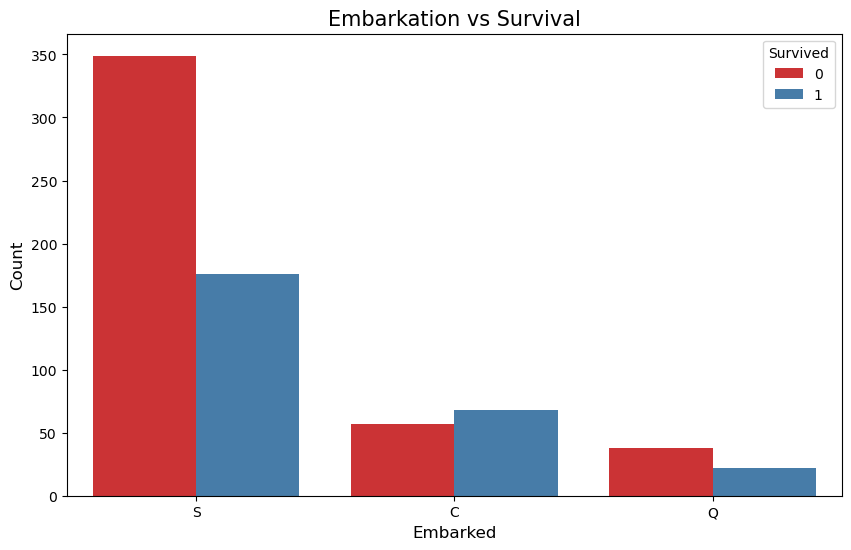

Embarked
C    54.400000
Q    36.666667
S    33.523810
Name: Survived, dtype: float64


In [137]:
# Embarkation vs Survival
plt.figure(figsize=(10,6))

# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(str)

sns.countplot(x='Embarked', hue='Survived', data=train_df, palette='Set1')

plt.title('Embarkation vs Survival', fontsize=15)
plt.xlabel('Embarked', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Survived', loc='upper right')
plt.show()


train_df['Survived'] = train_df['Survived'].astype(np.int64)


# Survival probability by embarkation port
embarked_survival_rate = train_df.groupby('Embarked')['Survived'].mean() * 100
print(embarked_survival_rate)


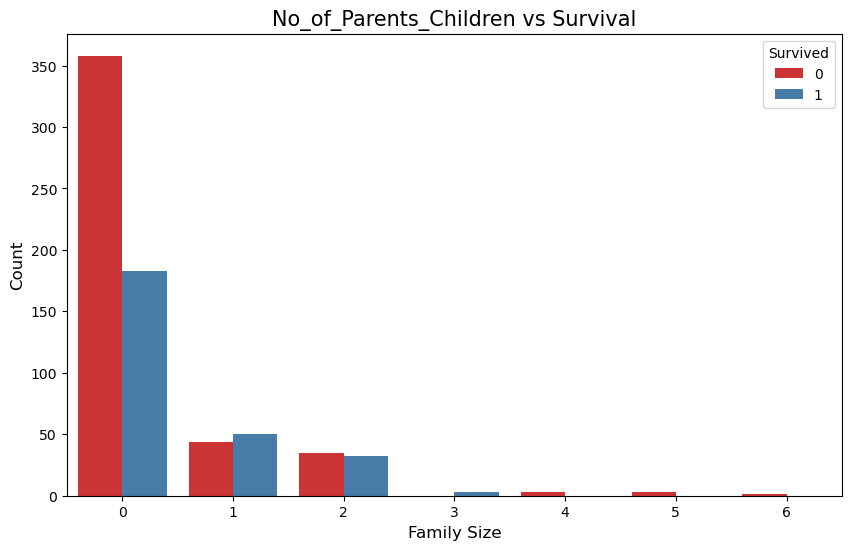

Parch
0     33.826248
1     53.191489
2     47.761194
3    100.000000
4      0.000000
5      0.000000
6      0.000000
Name: Survived, dtype: float64


In [138]:
# Family size vs Survival stacked bar chart
plt.figure(figsize=(10,6))

# Temporarily convert 'Label' to string for plotting
train_df['Survived'] = train_df['Survived'].astype(str)

sns.countplot(x='Parch', hue='Survived', data=train_df, palette='Set1')
plt.title('No_of_Parents_Children vs Survival', fontsize=15)
plt.xlabel('Family Size', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Survived', loc='upper right')
plt.show()

train_df['Survived'] = train_df['Survived'].astype(np.int64)



# Family size survival probability
family_size_survival_rate = train_df.groupby('Parch')['Survived'].mean() * 100
print(family_size_survival_rate)

# Pre-Processing Pipeline

In [139]:

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine datasets for consistent preprocessing
combine = [train_df, test_df]



# Fill missing 'Age' and 'Fare' values ; 'Embarked' values
for dataset in combine:
    # mode and median didn't have much change on the results
    dataset['Age'].fillna(dataset['Age'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].mode()[0], inplace=True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)


# Extract Titles from Names ; Made the results more accurate
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


# Simplify titles
title_mapping = {
    "Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Col": 7, "Major": 7, "Mlle": 8, 
    "Countess": 9, "Ms": 2, "Lady": 9, "Jonkheer": 10, "Don": 11, "Dona": 11, "Mme": 3, "Capt": 7, "Sir": 11}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping).fillna(0)


# Feature engineering ; additional DOMAIN SPECIFIC features
for dataset in combine:
    dataset['FamilySize']     = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['FamilySize_and_Age'] = dataset['FamilySize'] * dataset['Age']
    dataset['Pclass_Fare'] = dataset['Pclass'] * dataset['Fare']
    dataset['Pclass_Age'] = dataset['Pclass'] * dataset['Age']
    dataset['Fare_per_Person'] = dataset['Fare'] / dataset['FamilySize']
    dataset['is_Alone'] = np.where((dataset['SibSp'] == 0) & (dataset['Parch'] == 0), 1, 0)

# Drop unnecessary columns
train_df.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1, inplace=True)
test_df.drop (['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1, inplace=True)


# Convert categorical features to numeric
label_encoder = LabelEncoder()


for dataset in combine:
    dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
    
train_df = pd.get_dummies(train_df, columns=['Embarked'], drop_first=True)
test_df  = pd.get_dummies(test_df, columns=['Embarked'], drop_first=True)

# THis is what intuitions says, but it did not give the best results
# train_df.drop(['Embarked'], axis=1, inplace=True)
# test_df.drop(['Embarked'], axis=1, inplace=True)

# Feature scaling
scaler = StandardScaler()
train_df[['Fare', 'Age']] = scaler.fit_transform(train_df[['Fare', 'Age']])
test_df[['Fare', 'Age']] = scaler.transform(test_df[['Fare', 'Age']])

# Split data for training
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']

#### Correlation between Features

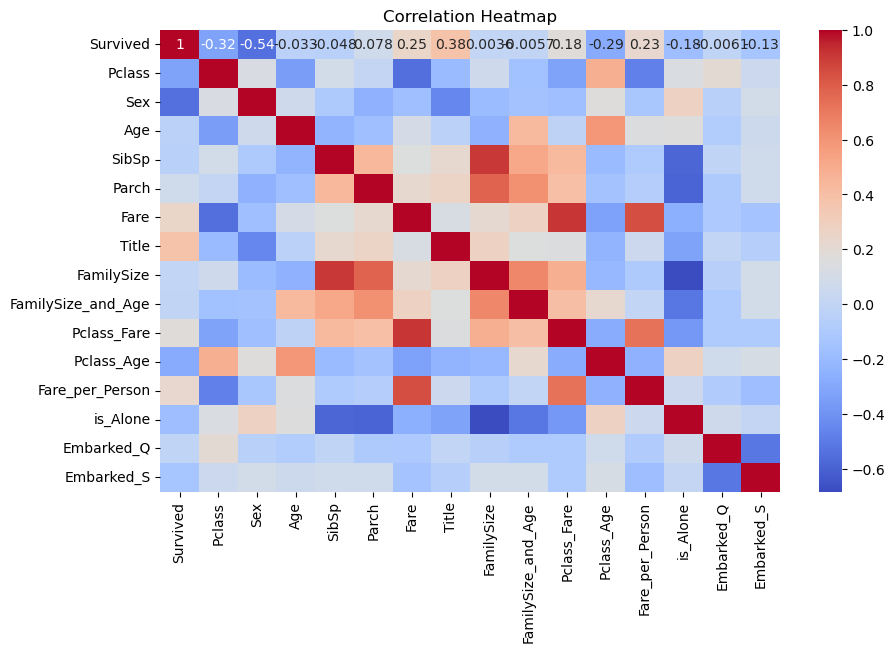

In [140]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Model Training

## Single Decision Tree

In [141]:
# Decision Tree with GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 7, 10, 20, 30, 50 ],  # Explore deeper trees
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4 ],
    'max_features': ['sqrt', 'log2', None],  # Trying different max_features for random selection
}

# Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2} => 79.65 %
# Best Parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2} => 80.54 %
# Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2} => 72.54 %


clf = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters:", grid_search_dt.best_params_)


# Training model with the best parameters
best_dt = grid_search_dt.best_estimator_

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}


## Hyperparameter Tuning and Training - Random Forest

In [142]:
# Random Forest Classifier with GridSearchCV
rf = RandomForestClassifier(random_state=42)

# Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300} => 82.64
# Best parameters for Random Forest: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 500} => 81.56
# Best parameters for Random Forest: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 700} => 84.96

# Define hyperparameters to tune
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Best parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Final model with best parameters
best_rf = grid_search_rf.best_estimator_

Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 100}


## Hyperparameter Tuning and Training - XGBoost

In [143]:
# XGBoost Classifier with GridSearchCV
xgb_model = XGBClassifier(random_state=42)

# Define hyperparameters to tune
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.6, 0.8]
}

# Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}  => 86.033 % [CURRENT BEST]
# Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6} => 81.64
# Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}  => 74.32

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Final model with best parameters
best_xgb = grid_search_xgb.best_estimator_

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


# Comparing XGBoost and Random Forest with Single Decision Tree

Decision Tree Performance:
Confusion Matrix:
[[78  9]
 [17 39]]

Accuracy: 0.8182
Precision: 0.8125
Recall: 0.6964
F1-Score: 0.7500

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        87
           1       0.81      0.70      0.75        56

    accuracy                           0.82       143
   macro avg       0.82      0.80      0.80       143
weighted avg       0.82      0.82      0.82       143



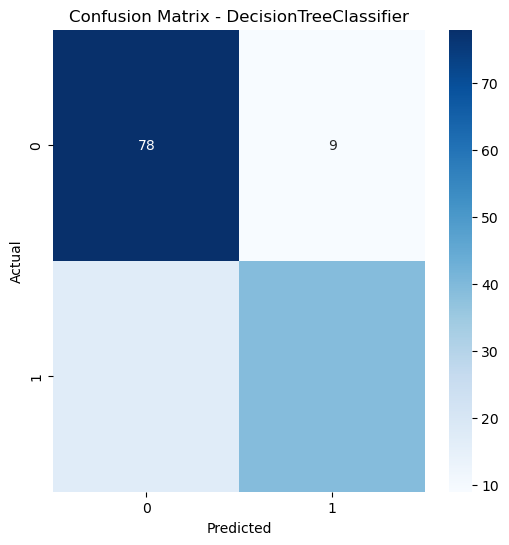

Random Forest Performance:
Confusion Matrix:
[[74 13]
 [13 43]]

Accuracy: 0.8182
Precision: 0.7679
Recall: 0.7679
F1-Score: 0.7679

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        87
           1       0.77      0.77      0.77        56

    accuracy                           0.82       143
   macro avg       0.81      0.81      0.81       143
weighted avg       0.82      0.82      0.82       143



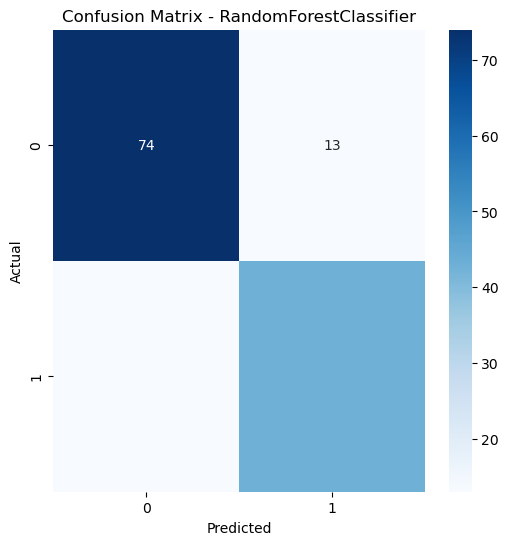

XGBoost Performance:
Confusion Matrix:
[[75 12]
 [12 44]]

Accuracy: 0.8322
Precision: 0.7857
Recall: 0.7857
F1-Score: 0.7857

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        87
           1       0.79      0.79      0.79        56

    accuracy                           0.83       143
   macro avg       0.82      0.82      0.82       143
weighted avg       0.83      0.83      0.83       143



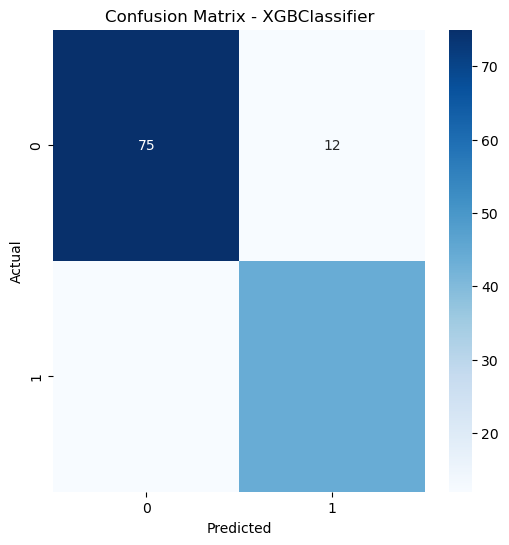

In [144]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. Fitting and evaluating models (Decision Tree, Random Forest, XGBoost)

# Helper function to print metrics
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    
    # Confusion Matrix
    print(f"Confusion Matrix:\n{confusion_matrix(y_val, y_pred)}\n")
    
    # Accuracy, Precision, Recall, F1-Score
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_val, y_pred):.4f}")
    
    # Classification Report
    print(f"\nClassification Report:\n{classification_report(y_val, y_pred)}")
    
    # Plot Confusion Matrix using sns.heatmap
    conf_matrix = confusion_matrix(y_val, model.predict(X_val))
    plt.figure(figsize=(6,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {type(model).__name__}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

# Decision Tree
best_dt.fit(X_train_split, y_train_split)
print("Decision Tree Performance:")
evaluate_model(best_dt, X_val, y_val)

# Random Forest
best_rf.fit(X_train_split, y_train_split)
print("Random Forest Performance:")
evaluate_model(best_rf, X_val, y_val)

# XGBoost
best_xgb.fit(X_train_split, y_train_split)
print("XGBoost Performance:")
evaluate_model(best_xgb, X_val, y_val)

In [145]:
# Print the best scores
print(f"Decision Tree Best Score: {grid_search_dt.best_score_}")
print(f"Random Forest Best Score: {grid_search_rf.best_score_}")
print(f"XGBoost Best Score: {grid_search_xgb.best_score_}")

Decision Tree Best Score: 0.806155816014971
Random Forest Best Score: 0.8272136314389836
XGBoost Best Score: 0.832847434255885


# Make Predictions

In [146]:
# Predict on test data using Single Decision Tree, Random Forest, XGBoost
dt_predictions  = best_dt.predict(test_df)
rf_predictions  = best_rf.predict(test_df)
xgb_predictions = best_xgb.predict(test_df)


submission_dt = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv')['PassengerId'],
    'Survived': dt_predictions
})

submission_rf = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv')['PassengerId'],
    'Survived': rf_predictions
})

submission_xgb = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv')['PassengerId'],
    'Survived': xgb_predictions
})


submission_dt.to_csv('./submissions/submission_6.csv', index=False)
submission_rf.to_csv('./submissions/submission_Random_Forst_Better_Title_Wieghts_11.csv', index=False)
submission_xgb.to_csv('./submissions/submission_XGBoost_Better_TitleWieghts_11.csv', index=False)  
# XGBoost gave the Highest accuracy ( 86.033 % ) 

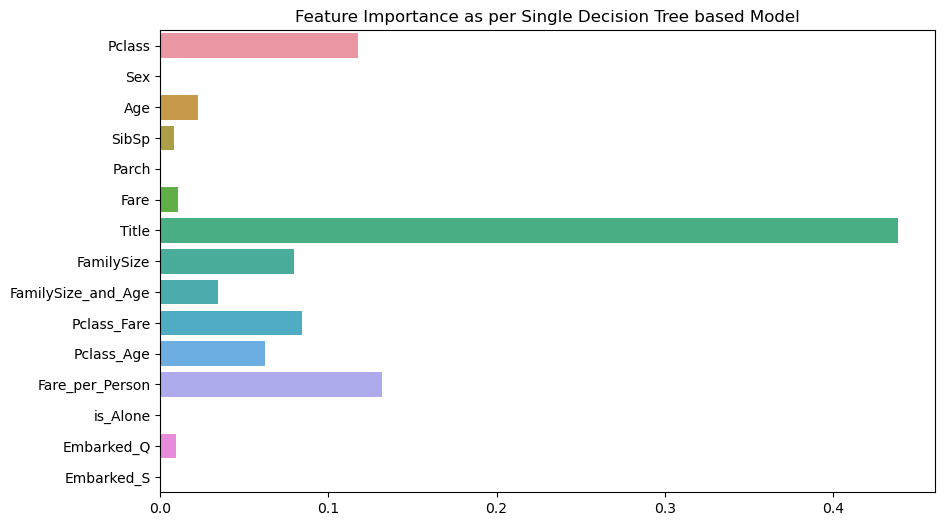

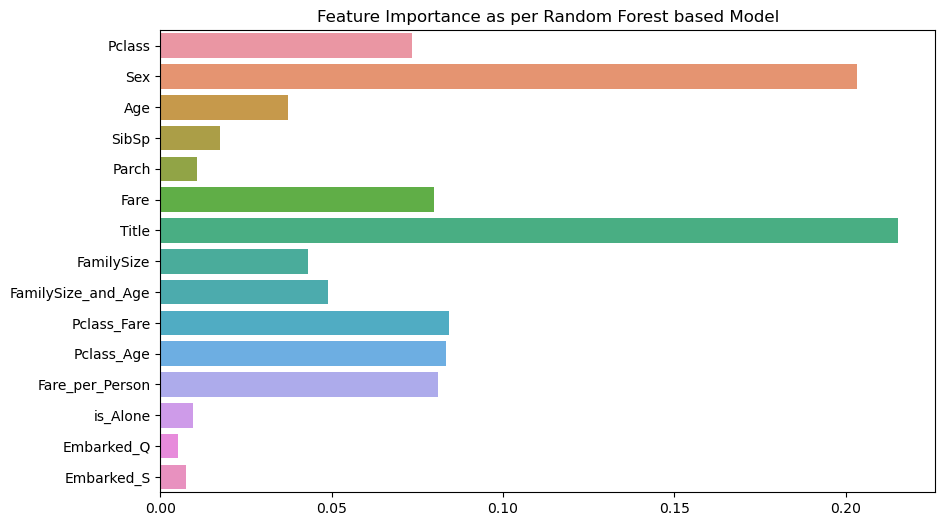

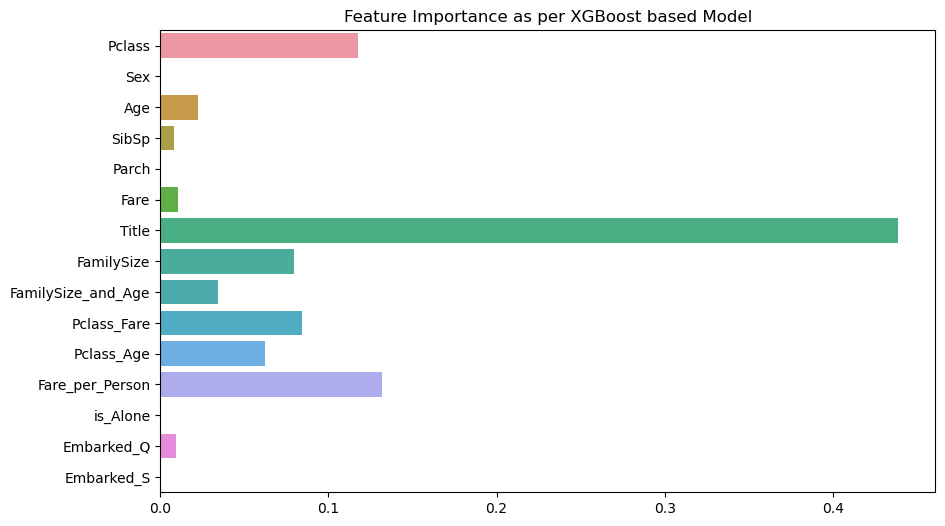

In [147]:
# Display feature importance

# [Title, Sex, Pclass] are almost always the top 3 ; but as I started tweaking the model, sometimes the importance of sex -> 0 and importance of Pclass and Title increase
# and Overall accuracy increases, that is WHY eventhough importance of feature `Sex` is 0, Model still performs very well.


plt.figure(figsize=(10, 6))
sns.barplot(x=best_dt.feature_importances_, y=X_train.columns)
plt.title("Feature Importance as per Single Decision Tree based Model")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=best_rf.feature_importances_, y=X_train.columns)
plt.title("Feature Importance as per Random Forest based Model")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=best_dt.feature_importances_, y=X_train.columns)
plt.title("Feature Importance as per XGBoost based Model")
plt.show()